# Homework assignments (For who needs an exam grade)

### We are given a dataset containing 510 images which are categorized according two main characteristics/properties: “C1” and “C2”. The following inputs are available:
* #### `input image', a 110 × 110 × 3 real-valued tensor. The last dimension denotes the number of input channels; the images belong to different combinations of the two properties C1 and C2. For C1 and C2 we have 5 and 6 possible values, respectively;  among the 30 possible couples (C1,C2), we have images for only 24 of them. We have around 20 samples (little more or less) for each of the available couples;  values in each tensor entry are integers in [0, 255];
* #### C1, string, the value for the C1 property. 5 possible values;
* #### C2, string, the value for the C2 property. 6 possible values.

### Design a deep neural network model to predict the class of an image, given by the couple (C1,C2).

### Provide a sketch of each of the following points, then implement your solution.
1. MODEL: Which architecture do you consider the most appropriate for this task, and why;
2. INPUT:
* After a potential preprocessing step, which is the input of the model, and
how is it represented;
3. OUTPUT: How would you design the output layer and why;
4. LOSS: Which loss function would you use to train your model and why;
5. MODEL CONFIGURATION:
 Model composition (composition of layers, regardless their number,
or their dimension, which can be object of tuning)
6. MODEL EVALUATION: How would you assess (in which setting) the
generalization capabilities of the model on unseen data?


In [1]:
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
import numpy as np
import matplotlib.pyplot as plt
from torchvision.transforms import ToTensor, Normalize, Compose

In [2]:
import pickle as pk
# Open the pickle data
with open('input.pkl', 'rb') as f:
  data = pk.load(f)

images = data['imgs']
C1 = data['C1']
C2 = data['C2']
print(f"length image:{len(images)}")
print(f"length C1:{len(C1)}")
print(f"length C2:{len(C2)}")

length image:510
length C1:510
length C2:510


In [3]:
print(type(images[0]))

<class 'numpy.ndarray'>


In [4]:
print(images[0].shape)

(110, 110, 3)


In [5]:
a = set(C1)
b = set(C2)
print(a, b)

{'dress', 'shoes', 'pants', 'shorts', 'shirt'} {'green', 'red', 'black', 'white', 'blue', 'brown'}


In [6]:
def get_class_labels_from_c1(list):
    result = list.copy()
    for i in range(len(list)):
        obj = list[i]
        if obj == 'dress':
            c = 0
        if obj == 'shoes':
            c = 1
        if obj == 'shirt':
            c = 2
        if obj == 'shorts':
            c = 3
        if obj == 'pants':
            c = 4
        result[i] = c
    return result
labels_c1 = get_class_labels_from_c1(C1)

In [7]:
def show_img(i, images):
    plt.imshow(images[i])
    print(f'C1: {C1[i]}, C2: {C2[i]}')
    plt.show()

In [8]:
def swap(imgs):
    swapped_imgs = imgs.copy()
    for n in range(len(swapped_imgs)):
        test_swapped = swapped_imgs[n].copy()
        test_swapped[:,:,0], test_swapped[:,:,2] = swapped_imgs[n][:,:,2], swapped_imgs[n][:,:,0]
        swapped_imgs[n] = test_swapped
    return swapped_imgs


In [9]:
proper_imgs = swap(images)

C1: dress, C2: black

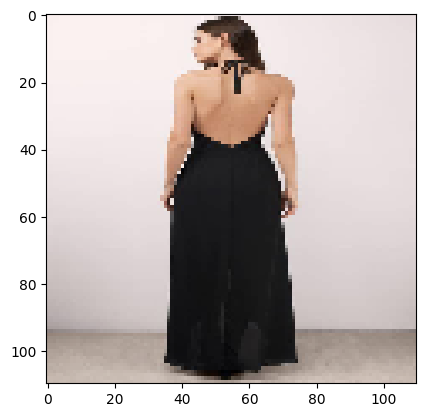

In [10]:
for i in range(1):
    show_img(i, proper_imgs)

Creating custom dataset

In [11]:
import torch
from torch.utils.data import Dataset
import numpy as np

my_preprocess = Compose([ToTensor(),
                        Normalize((0,), (1,))])

class NumpyArrayDataset(Dataset):
    def __init__(self, data, labels_c1, transform=None):
        self.data = data
        self.labels_c1 = labels_c1
        self.transform = transform


    def __len__(self):
        return len(self.data)

    def __getitem__(self, index):
        image = self.data[index]
        label_c1 = self.labels_c1[index]
        # Assuming the images are in the format (channels, height, width)
        # You may need to transpose if the format is different
        #image_tensor = torch.from_numpy(image).float()
        #label_c1_tensor = torch.Tensor([label_c1])
        #label_c1_tensor = torch.squeeze(label_c1_tensor)
        #label_c1_tensor = label_c1_tensor.long()
        #print('The c1 label you want go get is: ',(label_c1))
        #print('The c1 tensor you want go get is: ',(label_c1_tensor))
        if self.transform:
            image = self.transform(image)
        #image = torch.transpose(image, 0, 2) This would be necesary if we wanted to view the images
        #image = torch.transpose(image, 0, 1)

        return image, label_c1

# Example usage
# Assuming you have a list of numpy arrays called 'image_list'
# Convert them to a PyTorch dataset
dataset = NumpyArrayDataset(proper_imgs, labels_c1, my_preprocess)

# You can then use this dataset with a PyTorch DataLoader for batching, shuffling, etc.
# Example:
# from torch.utils.data import DataLoader
# dataloader = DataLoader(dataset, batch_size=64, shuffle=True)


In [12]:
from torch.utils.data import DataLoader
dataloader = DataLoader(dataset, batch_size=64, shuffle=True)

In [13]:
# possibly extract a validation dataset
from torch.utils.data import random_split
val_size = 60

# for reproducibility
torch.manual_seed(1)

train_size = len(dataset) - val_size
train_data, val_data = random_split(dataset, [train_size, val_size])
len(train_data), len(val_data)

(450, 60)

Creating Dataloader

In [14]:
# we'll use a batch size of 128 for training our network
batch_size = 128

# initialize a DataLoader object for each dataset
train_dataloader = torch.utils.data.DataLoader(train_data,
                                               batch_size=batch_size,
                                               shuffle=True)
val_dataloader = torch.utils.data.DataLoader(val_data,
                                               batch_size=batch_size)



# grab the first batch from one of our DataLoader objects
example_batch_img, example_batch_label = next(iter(train_dataloader))

# inputs and labels are batched together as tensor objects
print(f"Batch inputs shape: {example_batch_img.shape}, Batch labels shape: {example_batch_label.shape}")

Batch inputs shape: torch.Size([128, 3, 110, 110]), Batch labels shape: torch.Size([128])


Creating a model

In [15]:
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=3,
                               out_channels=32,
                               kernel_size = 3,
                               padding='same')
        self.conv2 = nn.Conv2d(in_channels=32,
                               out_channels=64,
                               kernel_size = 3,
                               padding='same')
        self.conv3 = nn.Conv2d(in_channels=64,
                               out_channels=128,
                               kernel_size = 3,
                               padding='same')
        self.dropout1 = nn.Dropout(0.1)
        self.dropout2 = nn.Dropout(0.1)
        self.dropout3 = nn.Dropout(0.1)
        # dim (28-3)/1 +1 = 26
        #  feature map dim 26x26x32
        ### Alternative to line 26: uncomment next line and line 27,
        ###   and commment line 26 to
        ###   use torch.nn instead of torch.nn.functional
        #self.relu = nn.ReLU()
        # dim 24 x 24 x 64
        self.maxpool2d = nn.MaxPool2d(kernel_size=2, stride=2)
        # dim 12x12 x 64, 'same' = 9216
        #self.dropout1 = nn.Dropout(0.25)
        self.fc1 = nn.Linear(21632, 5)
        #self.dropout2 = nn.Dropout(0.25)
        #self.fc2 = nn.Linear(128, 10)

    def forward(self, x):
        #print('zaczyna sie forward. x.shape = ', x.shape)
        x = self.conv1(x)
        x = F.relu(x)
        x = self.maxpool2d(x)
        x = self.dropout1(x)
        #x = self.relu(x)
        x = self.conv2(x)
        x = F.relu(x)
        x = self.maxpool2d(x)
        x = self.dropout2(x)
        x = self.conv3(x)
        x = F.relu(x)
        x = self.maxpool2d(x)
        x = self.dropout3(x)
        #print(x.shape)
        x = torch.flatten(x, 1)
        #print(x.shape)
        x = self.fc1(x)
        output = F.log_softmax(x, dim=1)
        return output

In [21]:
#Creating the model
model = CNN()
print(model)

# calling the method on one batch
it = iter(train_dataloader)
X_batch, y_batch = next(it)
print(model.forward(X_batch).shape)

CNN(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=same)
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=same)
  (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=same)
  (dropout1): Dropout(p=0.1, inplace=False)
  (dropout2): Dropout(p=0.1, inplace=False)
  (dropout3): Dropout(p=0.1, inplace=False)
  (maxpool2d): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=21632, out_features=5, bias=True)
)
torch.Size([128, 5])


In [17]:
import torch
if torch.cuda.is_available():
  dev = "cuda:0"
else:
  dev = "cpu"
print(dev)
device = torch.device(dev)

cpu


Training

In [22]:
# Computing the accuracy of a test set
def evaluate(model, test_loader, error):
#model = mlpinplace=False
    #print('evaluate start')
    model.eval()
    with torch.no_grad():
        correct = 0
        cur_loss = 0;
        #print('wchodze do petli')
        for test_imgs, test_labels in test_loader:
            #print("przetwarzam obrazek")
            #test_imgs, test_labels = test_imgs.cuda(), test_labels.cuda()
            output = model(test_imgs)
            test_labels = torch.squeeze(test_labels)
            test_labels = test_labels.long()
            loss = error(output, test_labels)
            cur_loss+=loss.item()
            predicted = torch.max(output,1)[1]
            correct += (predicted == test_labels).sum()
    model.train()
    return cur_loss/len(test_loader.dataset), correct/len(test_loader.dataset)



#training the model
def fit(model, train_loader, error, test_loader, epochs):
    optimizer = torch.optim.Adam(model.parameters(),lr=0.001)#,lr=0.001, betas=(0.9,0.999))


    model.train()
    train_losses = []
    test_losses = []

    for epoch in range(epochs):
        #print(f'Start of epoch {epoch}')
        cur_loss = 0
        correct = 0
        for X_batch, y_batch in train_loader:
            #print('Start of Batch')
            # moving data to GPU
            #X_batch, y_batch = X_batch.cuda(), y_batch.cuda()
            optimizer.zero_grad()
            output = model(X_batch)
            #y_batch = torch.squeeze(y_batch)
            #y_batch = y_batch.long()
            loss = error(output, y_batch)
            cur_loss+= loss.item()
            loss.backward()
            optimizer.step()

        train_losses.append(cur_loss/len(train_loader.dataset))

        test_loss, accuracy = evaluate(model, test_loader, error)
        test_losses.append(test_loss)
        print(f'Epoch : {epoch},  train loss:{train_losses[-1]}, test loss:{test_losses[-1]}, accuracy = {accuracy}')

    return train_losses, test_losses

In [23]:
for X_batch, y_batch in train_dataloader:
    print(y_batch.shape)
    print(type(y_batch[0]))

torch.Size([128])
<class 'torch.Tensor'>
torch.Size([128])
<class 'torch.Tensor'>
torch.Size([128])
<class 'torch.Tensor'>
torch.Size([66])
<class 'torch.Tensor'>


In [24]:
epochs = 50
error = nn.CrossEntropyLoss() # Loss for multiclass classification
train_losses, test_losses = fit(model,train_dataloader, error, val_dataloader, epochs)

Epoch : 0,  train loss:0.01527584711710612, test loss:0.02647076447804769, accuracy = 0.3166666626930237


KeyboardInterrupt: 

Chack if new version was uploaded